## References

* Deep Learning with python, second edition. Chapter 10.

## Install libraries

In [1]:
!pip3 install -q tensorflow keras

## Data

### Download

In [4]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip -y jena_climate_2009_2016.csv.zip

'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


'unzip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


### Load

Load data:

In [1]:
import os
fname = os.path.join("../data/jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In this dataset, 14 different quantities (such as temperature, pressure, humidity, and wind direction) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

In [7]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

`temperature` holds the observed values of the data that we want to predict and `raw_data` holds all the numeric variables, including temperature.

### Plot the data

Plot the temperature over time:

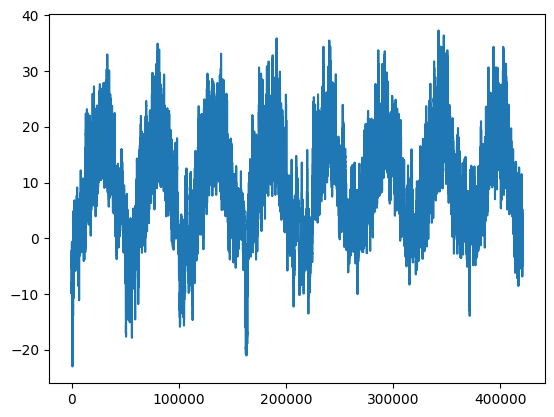

In [8]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

First 10 days of temperature data. 24 * 6 = 144 data points per day.

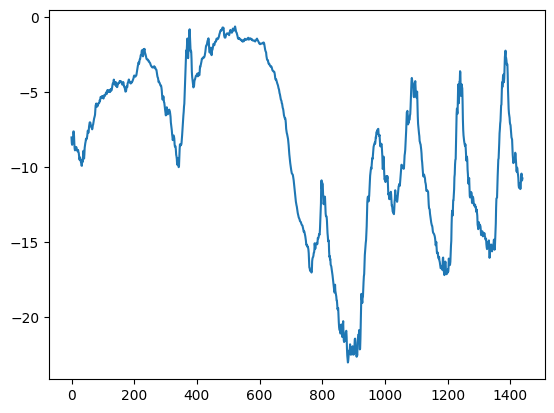

In [9]:
plt.plot(range(1440), temperature[:1440])

## Task

Given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

This notebook contains sample code for:

* Feedforward neural network
* 1D convolution neural network
* 3 variations of recurring neural network

Optimize the three classes of models above to give the best MAE. In addtion, use a transformer to compete in terms of MAE.

This [page](https://keras.io/examples/timeseries/timeseries_classification_transformer/) contains a reference of using a Transformer for time-series data.

The sample code below is a starting point. Your job is to extract the most value out of the models mentioned above. You are free to go beyond what is requested here and try out different models if you like.

Return a `.ipynb` containing the code (one section per model) and start the document with a summary of the models you tried and their respective MAEs in a table.

**Deadline**: 05/12

### Prepare the data

Decide the number of data points that will be assigned to training, validation and test sets.

In [10]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


Normalize the data.

In [11]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Create `tensorflow.data.Dataset` for training, validation and test splits:

In [12]:
import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

Check the input dimensions:

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Use naive model as baseline:

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## Feedforward neural network

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 15ms/step - loss: 12.2687 - mae: 2.7108 - val_loss: 11.6537 - val_mae: 2.7002
Epoch 2/10
819/819 [==============================] - 18s 21ms/step - loss: 9.0975 - mae: 2.3687 - val_loss: 11.4862 - val_mae: 2.6735
Epoch 3/10
819/819 [==============================] - 17s 21ms/step - loss: 8.3191 - mae: 2.2698 - val_loss: 11.9318 - val_mae: 2.7400
Epoch 4/10
819/819 [==============================] - 16s 20ms/step - loss: 7.7881 - mae: 2.1985 - val_loss: 10.9869 - val_mae: 2.6188
Epoch 5/10
819/819 [==============================] - 16s 19ms/step - loss: 7.4527 - mae: 2.1512 - val_loss: 10.7017 - val_mae: 2.5833
Epoch 6/10
819/819 [==============================] - 17s 20ms/step - loss: 7.1901 - mae: 2.1137 - val_loss: 11.2240 - val_mae: 2.6358
Epoch 7/10
819/819 [==============================] - 16s 20ms/step - loss: 6.9792 - mae: 2.0813 - val_loss: 12.3208 - val_mae: 2.7784
Epoch 8/10
819/819 [==============================] - 

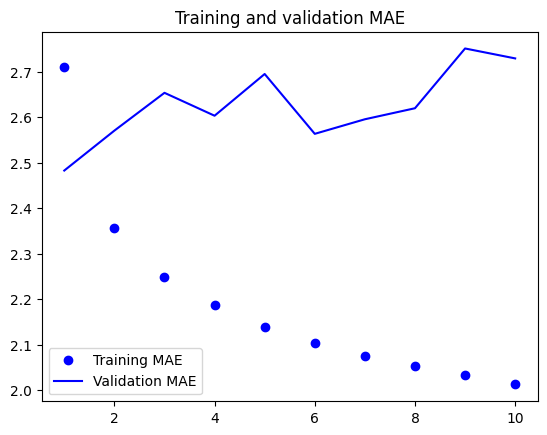

In [15]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 1D convolution neural network

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

In [18]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 16ms/step - loss: 23.2749 - mae: 3.8047 - val_loss: 18.4139 - val_mae: 3.4000
Epoch 2/10
819/819 [==============================] - 13s 15ms/step - loss: 15.5230 - mae: 3.1207 - val_loss: 14.5463 - val_mae: 3.0250
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 13.7639 - mae: 2.9356 - val_loss: 14.2367 - val_mae: 2.9895
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 12.8607 - mae: 2.8339 - val_loss: 13.5615 - val_mae: 2.9075
Epoch 5/10
819/819 [==============================] - 13s 15ms/step - loss: 12.2212 - mae: 2.7607 - val_loss: 14.4568 - val_mae: 3.0147
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 11.7124 - mae: 2.7020 - val_loss: 14.3182 - val_mae: 2.9903
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 11.2299 - mae: 2.6457 - val_loss: 14.8333 - val_mae: 3.0287
Epoch 8/10
819/819 [============================

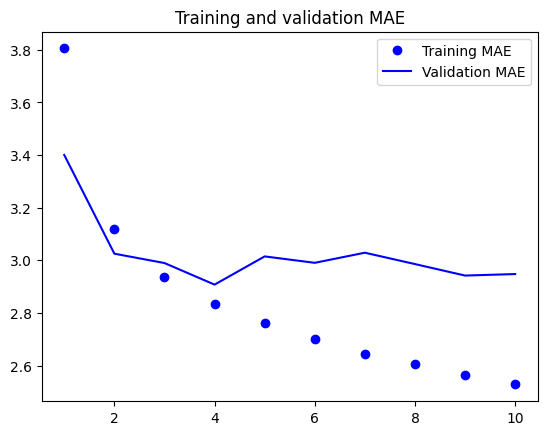

In [19]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## RNN with LSTM cell

In [20]:
import keras
from keras import layers

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 25s 30ms/step - loss: 44.4302 - mae: 4.8685 - val_loss: 13.2924 - val_mae: 2.7704
Epoch 2/10
819/819 [==============================] - 24s 30ms/step - loss: 11.1911 - mae: 2.5944 - val_loss: 10.7413 - val_mae: 2.4831
Epoch 3/10
819/819 [==============================] - 25s 30ms/step - loss: 10.0517 - mae: 2.4680 - val_loss: 9.4945 - val_mae: 2.3986
Epoch 4/10
819/819 [==============================] - 25s 30ms/step - loss: 9.6785 - mae: 2.4173 - val_loss: 9.7332 - val_mae: 2.4160
Epoch 5/10
819/819 [==============================] - 24s 30ms/step - loss: 9.3345 - mae: 2.3749 - val_loss: 9.6351 - val_mae: 2.4141
Epoch 6/10
819/819 [==============================] - 24s 30ms/step - loss: 9.0756 - mae: 2.3415 - val_loss: 10.6109 - val_mae: 2.4737
Epoch 7/10
819/819 [==============================] - 24s 30ms/step - loss: 8.8937 - mae: 2.3177 - val_loss: 10.7064 - val_mae: 2.5040
Epoch 8/10
819/819 [==============================] - 2

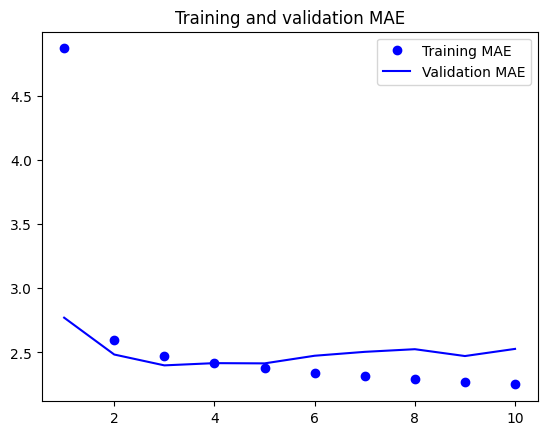

In [24]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## RNN with LSTM cell and recurrent dropout

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [26]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6016      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6049 (23.63 KB)
Trainable params: 6049 (23.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 68s 82ms/step - loss: 27.4771 - mae: 3.8642 - val_loss: 9.7172 - val_mae: 2.4380
Epoch 2/50
819/819 [==============================] - 67s 81ms/step - loss: 14.9045 - mae: 3.0006 - val_loss: 9.3520 - val_mae: 2.3765
Epoch 3/50
819/819 [==============================] - 67s 82ms/step - loss: 14.1340 - mae: 2.9132 - val_loss: 9.4616 - val_mae: 2.3848
Epoch 4/50
819/819 [==============================] - 66s 81ms/step - loss: 13.4593 - mae: 2.8447 - val_loss: 9.5603 - val_mae: 2.4069
Epoch 5/50
819/819 [==============================] - 67s 82ms/step - loss: 13.0053 - mae: 2.7883 - val_loss: 9.5383 - val_mae: 2.4052
Epoch 6/50
819/819 [==============================] - 66s 81ms/step - loss: 12.6874 - mae: 2.7527 - val_loss: 9.8109 - val_mae: 2.4397
Epoch 7/50
819/819 [==============================] - 66s 81ms/step - loss: 12.3014 - mae: 2.7161 - val_loss: 10.1385 - val_mae: 2.4824
Epoch 8/50
819/819 [==============================] - 

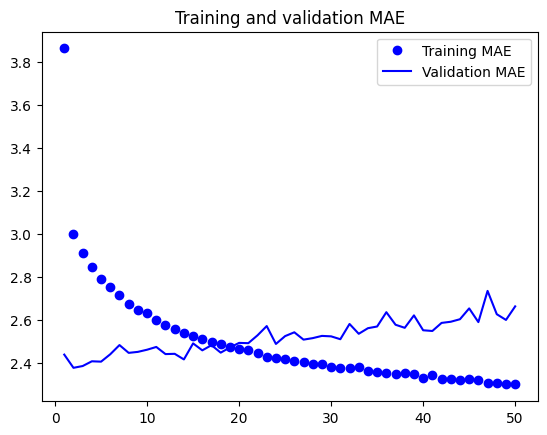

In [28]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Stacked RNN layers

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 142s 172ms/step - loss: 26.3065 - mae: 3.7720 - val_loss: 10.4601 - val_mae: 2.5255
Epoch 2/50
819/819 [==============================] - 142s 173ms/step - loss: 13.6321 - mae: 2.8568 - val_loss: 9.8368 - val_mae: 2.4439
Epoch 3/50
819/819 [==============================] - 142s 174ms/step - loss: 12.4769 - mae: 2.7306 - val_loss: 10.0937 - val_mae: 2.4758
Epoch 4/50
819/819 [==============================] - 142s 173ms/step - loss: 11.5680 - mae: 2.6314 - val_loss: 10.2498 - val_mae: 2.4925
Epoch 5/50
819/819 [==============================] - 142s 174ms/step - loss: 10.8748 - mae: 2.5471 - val_loss: 10.1394 - val_mae: 2.5081
Epoch 6/50
819/819 [==============================] - 142s 173ms/step - loss: 10.2750 - mae: 2.4737 - val_loss: 10.0864 - val_mae: 2.4920
Epoch 7/50
819/819 [==============================] - 141s 172ms/step - loss: 9.7846 - mae: 2.4076 - val_loss: 10.6001 - val_mae: 2.5501
Epoch 8/50
819/819 [================